This notebook shows how BigBang can help you analyze the senders in a particular mailing list archive, for the purposes of consolidating senders -- that is, entity resolution.

In [170]:
%matplotlib inline

Import the BigBang modules and other utilities as needed. These should be in your Python environment if you've installed BigBang correctly.

In [168]:
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import scipy.cluster.hierarchy as sch

Load some sample data for analysis.

In [6]:
urls = ["http://www.ietf.org/mail-archive/text/ietf-privacy/",
        "http://lists.w3.org/Archives/Public/public-privacy/"]
mlists = [mailman.open_list_archives(url,"../archives") for url in urls]
activities = [Archive(ml).get_activity() for ml in mlists]

Opening 36 archive files
Opening 17 archive files


Many mailing lists will have some duplicate senders: individuals who use multiple email addresses or are recorded as different senders when using the same email address. We want to identify those potential duplicates in order to get a more accurate representation of the distribution of senders.

In [15]:
consolidates = []

# alternative entity consolidation process, based on graph analysis
consolidates_g = process.resolve_sender_entities(activities[0], lexical_distance=8)
consolidates_g_reduced = {k: v for k,v in consolidates_g.iteritems() if len(v) > 1}

print str(len(consolidates_g_reduced)) + ' candidates for consolidation.'
print consolidates_g_reduced

6 candidates for consolidation.
{u'<mohamed.boucadair@orange.com>': [u'<mohamed.boucadair@orange.com>', u'<mohamed.boucadair@orange-ftgroup.com>'], u'Scott Brim <scott.brim@gmail.com>': [u'Scott Brim <scott.brim@gmail.com>', u'Scott W Brim <scott.brim@gmail.com>'], u'Eric Burger <eburger-l@standardstrack.com>': [u'Eric Burger <eburger-l@standardstrack.com>', u'Eric Burger <eburger@standardstrack.com>'], u'Hannes Tschofenig <hannes.tschofenig@gmx.net>': [u'Hannes Tschofenig <hannes.tschofenig@gmx.net>', u'Hannes Tschofenig <hannes.tschofenig@nsn.com>', u'Hannes Tschofenig <Hannes.Tschofenig@gmx.net>', u'"Hannes Tschofenig" <Hannes.Tschofenig@gmx.net>', u'Hannes Tschofenig <Hannes.Tschofenig@nsn.com>'], u'"Fred Baker (fred)" <fred@cisco.com>': [u'"Fred Baker (fred)" <fred@cisco.com>', u'Fred Baker <fred@cisco.com>'], u'Rhys Smith <smith@cardiff.ac.uk>': [u'Rhys Smith <smith@CARDIFF.AC.UK>', u'Rhys Smith <smith@Cardiff.ac.uk>', u'Rhys Smith <smith@cardiff.ac.uk>']}


In [16]:
a_consolidated = utils.repartition_dataframe(activities[0], consolidates_g)

print 'We removed: ' + str(len(activities[0].columns) - len(a_consolidated.columns)) + ' columns.'

We removed: 10 columns.


In [70]:
people = pd.DataFrame(a_consolidated.sum(0), columns=['Message Count'])

In [71]:
people['aka'] = None # new empty column
for k,v in consolidates_g_reduced.iteritems():
    people.ix[k, 'aka'] = ','.join(v)

For manual review purposes, it would be useful if the list of people were sorted in a way that's related to their lexical distance. This way, you might see names that the algorithm didn't assume were the same, but might have been fairly similar, close together in the list, making them easier to manually update. This sorting is tricky and can't be perfectly convenient; here, we'll use `scipy` to do a hierarchical clustering and then sort based on the order of the ultimate leaves.

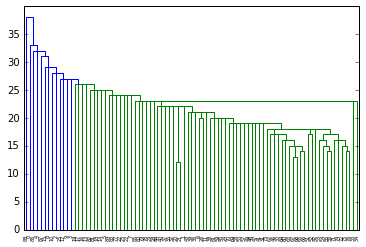

In [75]:
levdf = process.matricize(people.index, process.from_header_distance)
Y = sch.linkage(scipy.spatial.distance.squareform(levdf))
Z = sch.dendrogram(Y)
people = people.reindex(index=[levdf.index[x] for x in Z['leaves']])

Let's export the people list to CSV, including that AKA column, for further manual review.

In [77]:
del people['Message Count'] # we just care about exporting people/addresses for entity resolution
people.to_csv('people_entity_resolution-%s.csv'% mailman.get_list_name(urls[0]), encoding='utf-8')

If you review that spreadsheet, you should see individual people/addresses, and, for some, an AKA list. Our naive algorithm probably missed some; you can correct them manually by cutting an address from the first column and adding it to the aka column (comma-separated).

I've done that for `people_entity_resolution-ietf-privacy_updated.csv`. Now, we want to import that spreadsheet and re-import the mailing list activity and have it merged to match.

In [169]:
people_import = pd.read_csv('people_entity_resolution-ietf-privacy_updated.csv', encoding='utf-8', index_col=0, dtype=str)

In [166]:
activity = Archive(mailman.open_list_archives(urls[0],"../archives")).get_activity()
activity = pd.DataFrame(activity.sum(0), columns=['Message Count'])

Opening 36 archive files


In [167]:
activity_merged = people_import.merge(activity, how='outer', left_index=True, right_index=True)
activity_merged['aka'] = activity_merged['aka'].apply(str)

In [160]:
def authoritative_index_based_on_alternative_row(df, col, ind):
    for i, v in df[col].iteritems():
        alt_email_addresses = re.split('(?<=>)\,', str(v)) # split on comma only after the end of an email address in angle brackets
        if ind in alt_email_addresses:
            return i
    return ind

grouped = activity_merged.groupby(lambda x: authoritative_index_based_on_alternative_row(activity_merged, 'aka', x))

In [165]:
def join_non_empty(l):
    return ','.join([x for x in l if x not in ['', 'nan']])

activity_merged = grouped.agg({'Message Count': np.sum, 'aka': join_non_empty})
activity_merged

,Message Count,aka
"""Alexander Pretschner"" <alexander.pretschner@in.tum.de>",1.0,
"""Bryan McLaughlin (brmclaug)"" <brmclaug@cisco.com>",17.0,
"""Caspar Bowden \(travelling private e-mail\)"" <tharg@gmx.net>",1.0,
"""Fred Baker (fred)"" <fred@cisco.com>",11.0,"""Fred Baker (fred)"" <fred@cisco.com>,Fred Bake..."
"""Hanka, Oliver"" <oliver.hanka@tum.de>",1.0,
"""Horne, Rob"" <rob.horne@trustis.com>",4.0,
"""Jiankang Yao"" <yaojk@cnnic.cn>",1.0,
"""Joel M. Halpern"" <jmh@joelhalpern.com>",1.0,
"""Smith, Bill"" <bill.smith@paypal-inc.com>",1.0,
<Dirk.von-Hugo@telekom.de>,1.0,


Okay, we have properly consolidated columns (in this case, just Message Count and aka) for the people in our manually-adjusted input list, with aggregated message counts based on the aka column.